In [1]:
import pandas as pd
import numpy as np
from glob import glob
from scipy import stats
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes
import json
import random
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from transformer_lens import HookedTransformer
import torch
from jaxtyping import Float, Int
from collections import defaultdict, Counter
from sklearn.decomposition import TruncatedSVD
import itertools
from scipy.stats import linregress
import plotly_express as px
import torch.nn.functional as F
import pickle
import math
import seaborn as sns

In [2]:
def get_device_str() -> str:
    if torch.backends.mps.is_available():
        return "mps"
    else:
        return "cuda" if torch.cuda.is_available() else "cpu"


def get_feature_activations(sae, steps):
    feature_activations = []
    for _, s in enumerate(steps):
        active_feature_ids = s["active_feature_ids"]
        active_feature_acts = s["active_feature_acts"]
        feature_acts = torch.zeros(sae.W_enc.shape[1])
        feature_acts[active_feature_ids] = torch.tensor(active_feature_acts)
        feature_activations.append(feature_acts)
    return torch.stack(feature_activations)

In [3]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [4]:
perturbation_layer = "blocks.1.hook_resid_pre"
saes, sparsities = get_gpt2_res_jb_saes(perturbation_layer)
sae = saes[perturbation_layer].cpu()
sae.eval()
feature_sparsities = 10 ** sparsities[perturbation_layer].cpu()

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


## Feature interpolations

In [125]:
def interpolate_features(steps):
    start_active_ids = steps[0]["active_feature_ids"]
    start_active_feat_acts = steps[0]["active_feature_acts"]

    end_active_ids = steps[-1]["active_feature_ids"]
    end_active_feat_acts = steps[-1]["active_feature_acts"]

    all_active_feature_ids = list(set(start_active_ids + end_active_ids))
    all_active_feats = {k: {"start": 0, "end": 0} for k in all_active_feature_ids}

    for f_id, f_act in zip(start_active_ids, start_active_feat_acts):
        all_active_feats[f_id]["start"] = f_act

    for f_id, f_act in zip(end_active_ids, end_active_feat_acts):
        all_active_feats[f_id]["end"] = f_act

    interpolated_feature_acts = []

    for i in range(len(steps)):
        f_act = torch.zeros(sae.W_enc.shape[1])
        for f_id in all_active_feature_ids:
            f_range = all_active_feats[f_id]
            step_size = (f_range["end"] - f_range["start"]) / 100
            feat_step_act = f_range["start"] + (step_size * i)
            f_act[f_id] = feat_step_act
        interpolated_feature_acts.append(f_act)
    interpolated_feature_acts = torch.stack(interpolated_feature_acts)
    return interpolated_feature_acts

In [120]:
cos_sim_sae_enc_acts_and_acts = []
cos_sim_interp_acts_and_acts = []

l2_sae_enc_acts_and_acts = []
l2_interp_acts_and_acts = []

n_examples = 5000
idxs = random.sample(range(len(metadata)), n_examples)

for idx in idxs:
    steps = metadata[idx]["steps_metadata"]
    feature_acts = get_feature_activations(sae, steps)
    acts = torch.tensor(activations[idx])

    start_active_ids = steps[0]["active_feature_ids"]
    start_active_feat_acts = steps[0]["active_feature_acts"]

    end_active_ids = steps[-1]["active_feature_ids"]
    end_active_feat_acts = steps[-1]["active_feature_acts"]

    all_active_feature_ids = list(set(start_active_ids + end_active_ids))
    all_active_feats = {k: {"start": 0, "end": 0} for k in all_active_feature_ids}

    for f_id, f_act in zip(start_active_ids, start_active_feat_acts):
        all_active_feats[f_id]["start"] = f_act

    for f_id, f_act in zip(end_active_ids, end_active_feat_acts):
        all_active_feats[f_id]["end"] = f_act

    interpolated_feature_acts = []

    for i in range(100):
        f_act = torch.zeros(sae.W_enc.shape[1])
        for f_id in all_active_feature_ids:
            f_range = all_active_feats[f_id]
            step_size = (f_range["end"] - f_range["start"]) / 100
            feat_step_act = f_range["start"] + (step_size * i)
            f_act[f_id] = feat_step_act
        interpolated_feature_acts.append(f_act)
    interpolated_feature_acts = torch.stack(interpolated_feature_acts)

    decoded_orig_feat_acts = sae.decode(feature_acts)
    decoded_interpolated_feat_acts = sae.decode(interpolated_feature_acts)

    sim = F.cosine_similarity(decoded_orig_feat_acts, acts).mean().item()
    cos_sim_sae_enc_acts_and_acts.append(sim)

    sim = F.cosine_similarity(decoded_interpolated_feat_acts, acts).mean().item()
    cos_sim_interp_acts_and_acts.append(sim)

    l2_score = torch.norm(acts - decoded_orig_feat_acts, dim=1, p=2).sum().item()
    l2_sae_enc_acts_and_acts.append(l2_score)

    l2_score = (
        torch.norm(acts - decoded_interpolated_feat_acts, dim=1, p=2).sum().item()
    )
    l2_interp_acts_and_acts.append(l2_score)

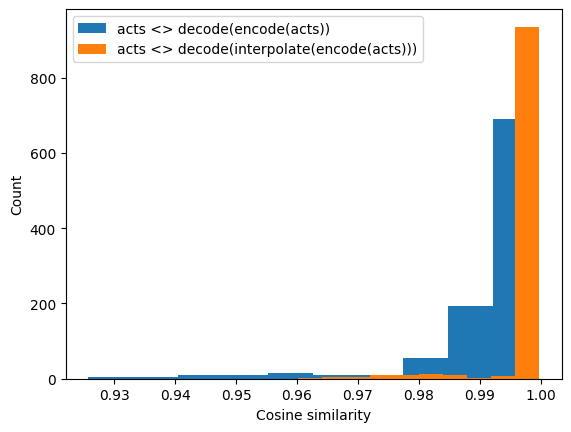

In [118]:
plt.hist(cos_sim_sae_enc_acts_and_acts, label="acts <> decode(encode(acts))")
plt.hist(
    cos_sim_interp_acts_and_acts, label="acts <> decode(interpolate(encode(acts)))"
)
plt.xlabel("Cosine similarity")
plt.ylabel("Count")
plt.legend()
plt.show()

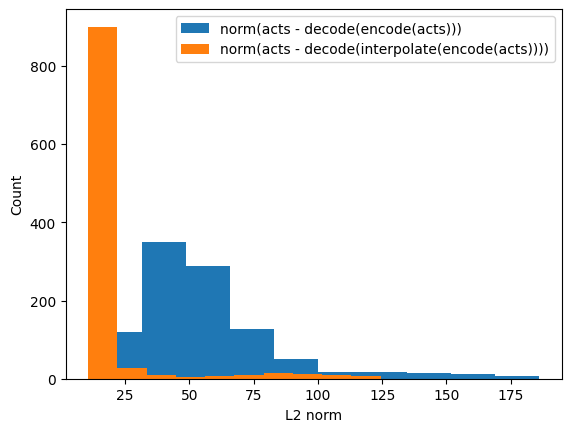

In [119]:
plt.hist(l2_sae_enc_acts_and_acts, label="norm(acts - decode(encode(acts)))")
plt.hist(
    l2_interp_acts_and_acts, label="norm(acts - decode(interpolate(encode(acts))))"
)
plt.xlabel("L2 norm")
plt.ylabel("Count")
plt.legend()
plt.show()

## Illustration figure for steps NL, MS, SF

In [96]:
def nl_step(values, end_step=10, threshold=20, l2_threshold=20):
    n = len(values)

    # Ensure we have enough data points
    if end_step >= n:
        raise ValueError(
            f"End step {end_step} is out of bounds for the list of length {n}."
        )

    # Calculate the slope (m) using values at start_step and end_step
    x1, y1 = 0, values[0]
    x2, y2 = end_step - 1, values[end_step - 1]
    slope = (y2 - y1) / (x2 - x1)

    # Calculate the intercept (b)
    intercept = y1 - slope * x1

    # Check deviations from step 10 onward
    for i in range(end_step, n):
        # Calculate the expected y value using the linear approximation
        expected_y = slope * i + intercept

        # Calculate the actual y value
        actual_y = values[i]

        # Calculate the percentage deviation
        deviation = abs(actual_y - expected_y) / expected_y * 100

        # Check if the deviation exceeds the threshold
        if deviation > threshold and values[i - 1] >= l2_threshold:
            return i - 1
    return n


def find_blowup_max_slope(dists, min_slope_threshold=0.02, num_steps=100):
    steps = list(range(len(dists)))

    slopes = []
    for i in range(1, len(steps)):
        dy = dists[i] - dists[i - 1]
        dx = steps[i] - steps[i - 1]
        slopes.append(dy / dx if dx != 0 else 0)

    # Pad the beginning of slopes list to match the length of steps
    slopes = [slopes[0]] + slopes

    if not any(np.array(slopes) > min_slope_threshold):
        return num_steps - 1

    ms_step = np.argsort(np.nan_to_num(slopes))[::-1][0]

    return ms_step


def calculate_auc(values):
    # Create x values corresponding to the indices of the values
    x = np.arange(len(values))

    # Use numpy's trapezoidal rule to calculate the area under the curve
    auc = np.trapz(values, x)

    return auc


def max_space_ratio_step(values):
    aucs = []
    for i in range(1, len(values)):
        auc = calculate_auc(values[:i])
        if auc == 0:
            aucs.append(0)
            continue
        triangle_area = (values[i - 1] * i) / 2
        aucs.append(triangle_area / auc)
    return np.argmax(aucs[5:]) + 5


def load_graph_pickle(filename):
    """Load the graph using pickle."""
    with open(filename, "rb") as f:
        return pickle.load(f)


def load_jsonl(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            # Parse each line as a JSON object
            json_object = json.loads(line.strip())
            data.append(json_object)
    return data


def find_activation_plateau_length(dists, threshold=20):
    for i, d in enumerate(dists):
        if d >= threshold:
            return i
    return 100

In [54]:
metadata, activations = [], []

pert_type = "other_act"
n_files = 5

for path in sorted(glob(f"replications/{pert_type}_metadata*"))[:n_files]:
    metadata.extend(load_jsonl(path))

for path in sorted(glob(f"replications/{pert_type}_acts*"))[:n_files]:
    activations.append(np.load(path))

activations = np.concatenate(activations)

In [115]:
# idx = 23
# steps = metadata[idx]["steps_metadata"]
# pert_l2_dists = [s["read_layer_l2_norm"] for s in steps]

# plt.plot(pert_l2_dists)

In [56]:
idxs = [2, 4, 5, 18, 23]

In [75]:
# for idx in idxs:
#     steps = metadata[idx]["steps_metadata"]
#     pert_l2_dists = [s["read_layer_l2_norm"] for s in steps]
#     plt.plot(pert_l2_dists, label=idx)

# plt.legend()

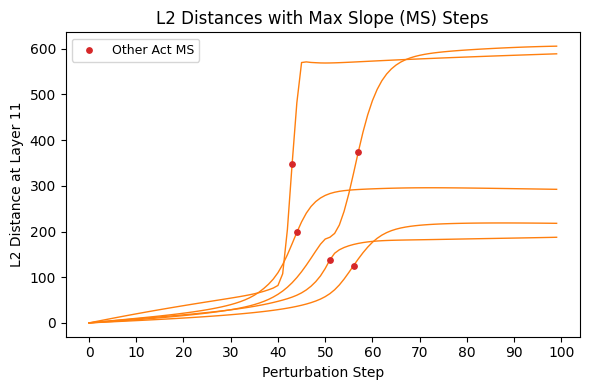

In [114]:
# Create the plot with a larger figure size
fig, ax = plt.subplots(figsize=(6, 4))


for i, idx in enumerate(idxs):
    label = i == 0
    steps = metadata[idx]["steps_metadata"]
    pert_l2_dists = [s["read_layer_l2_norm"] for s in steps]

    ms_blowup_step = find_blowup_max_slope(pert_l2_dists)

    # Plot the main line
    ax.plot(pert_l2_dists, linewidth=1, color="tab:orange")

    ms_label = "Other Act MS" if label else None
    ax.scatter(
        ms_blowup_step,
        pert_l2_dists[ms_blowup_step],
        color="tab:red",
        s=15,
        zorder=3,
        label=ms_label,
        marker="o",
    )

# Customize the plot
ax.set_title("L2 Distances with Max Slope (MS) Steps")
ax.set_xlabel("Perturbation Step")
ax.set_ylabel("L2 Distance at Layer 11")
ax.legend(loc="upper left")

ax.set_xticks(np.arange(0, 101, 20))

ax.set_xticks(np.arange(0, 101, 10))

# Add grid for better readability
# ax.grid(True, linestyle='--', alpha=0.5, color='gray')

# Tight layout to use space efficiently
plt.tight_layout()
plt.legend(fontsize=9)

# Show the plot
plt.show()

## Feature activations distribution

In [27]:
import numpy as np
import torch
from sklearn.covariance import EmpiricalCovariance
from torch.distributions import MultivariateNormal
from sklearn.decomposition import PCA
import numpy as np
from scipy import stats
from scipy.stats import wasserstein_distance
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KernelDensity

In [39]:
def load_jsonl(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            # Parse each line as a JSON object
            json_object = json.loads(line.strip())
            data.append(json_object)
    return data


def generate_mean_cov(data, cov_method="full"):
    """
    Generate mean and covariance matrix for MultivariateNormal distribution.

    Args:
    data (numpy.ndarray): Input data of shape (n_samples, n_features)
    cov_method (str): Method to compute covariance. Options:
                      'full' - Full covariance matrix
                      'diag' - Diagonal covariance matrix
                      'sparse' - Sparse covariance matrix

    Returns:
    tuple: (data_mean, data_cov) as torch tensors
    """
    # Compute mean
    data_mean = torch.mean(data, dim=0)

    # Compute covariance
    if cov_method == "full":
        # Full covariance matrix
        data_cov = np.cov(data, rowvar=False)
    elif cov_method == "diag":
        # Diagonal covariance matrix
        data_cov = np.diag(np.var(data, axis=0))
    elif cov_method == "sparse":
        # Sparse covariance matrix
        ec = EmpiricalCovariance(assume_centered=False)
        ec.fit(data)
        data_cov = ec.covariance_
    else:
        raise ValueError("Invalid cov_method. Choose 'full', 'diag', or 'sparse'.")

    # Convert to torch tensors
    data_cov = torch.tensor(data_cov, dtype=torch.float32)

    return data_mean, data_cov


def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))


def evaluate_samples(original_data, generated_samples):
    results = {}

    # 1. Statistical Moments
    moment_functions = {
        "mean": np.mean,
        "std": np.std,
    }

    for moment, func in moment_functions.items():
        orig_moment = func(original_data, axis=0)
        gen_moment = func(generated_samples, axis=0)
        results[f"{moment}_mse"] = mean_squared_error(orig_moment, gen_moment)

    # 2. Wasserstein Distance
    results["wasserstein"] = np.mean(
        [
            wasserstein_distance(original_data[:, i], generated_samples[:, i])
            for i in range(original_data.shape[1])
        ]
    )

    # 3. KL Divergence (using KDE for estimation)
    kde_orig = KernelDensity().fit(original_data)
    kde_gen = KernelDensity().fit(generated_samples)

    log_dens_orig = kde_orig.score_samples(original_data)
    log_dens_gen = kde_gen.score_samples(original_data)

    results["kl_divergence"] = kl_divergence(
        np.exp(log_dens_orig), np.exp(log_dens_gen)
    )

    # 4. Sparsity
    orig_sparsity = np.mean(original_data == 0)
    gen_sparsity = np.mean(generated_samples == 0)
    results["sparsity_diff"] = abs(orig_sparsity - gen_sparsity)

    return results

In [9]:
metadata, activations = [], []

pert_type = "other_act"
n_files = 100

for path in sorted(glob(f"observations_layer1/metadata*"))[:n_files]:
    metadata.extend(load_jsonl(path))

for path in sorted(glob(f"observations_layer1/acts*"))[:n_files]:
    activations.append(np.load(path))

activations = np.concatenate(activations)

In [10]:
activations.shape

(32000, 100, 768)

In [46]:
all_feature_acts = []

for m in metadata[:10_000]:
    feature_acts = torch.zeros(sae.W_dec.shape[0])
    active_feature_ids = m["steps_metadata"][0]["active_feature_ids"]
    active_feature_acts = m["steps_metadata"][0]["active_feature_acts"]
    feature_acts[active_feature_ids] = torch.tensor(active_feature_acts)
    all_feature_acts.append(feature_acts)

all_feature_acts = torch.stack(all_feature_acts)

In [47]:
all_feature_acts.shape

torch.Size([10000, 24576])

In [48]:
pca = PCA(n_components=0.95)  # Capture 95% of variance
transformed_data = torch.tensor(pca.fit_transform(all_feature_acts))

# Sample in reduced space
distrib = MultivariateNormal(
    torch.mean(transformed_data, dim=0), torch.cov(transformed_data.T)
)
samples = distrib.sample([10])

# Transform back to original space
original_space_samples = pca.inverse_transform(samples)

In [37]:
samples.shape

torch.Size([10, 551])

In [40]:
eval_results = evaluate_samples(
    all_feature_acts.numpy(), original_space_samples.numpy()
)
print(eval_results)

{'mean_mse': 0.002336642129205098, 'std_mse': 0.0022766319086058163, 'wasserstein': 0.02352722515224498, 'kl_divergence': 0.0, 'sparsity_diff': 0.1835206298828126}


/tmp/ipykernel_4891/153261314.py:50: RuntimeWarning: invalid value encountered in divide
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


## Graph of feature interactions

In [5]:
import numpy as np
import networkx as nx
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from collections import defaultdict

In [6]:
def load_jsonl(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            # Parse each line as a JSON object
            json_object = json.loads(line.strip())
            data.append(json_object)
    return data

In [7]:
metadata, activations = [], []

n_files = 100

for path in sorted(glob(f"observations_layer1/metadata*"))[:n_files]:
    metadata.extend(load_jsonl(path))

for path in sorted(glob(f"observations_layer1/acts*"))[:n_files]:
    activations.append(np.load(path))

activations = np.concatenate(activations)

In [12]:
all_active_feature_ids = []
all_active_feature_acts = []
num_features = sae.W_dec.shape[0]

for m in metadata:
    feature_acts = torch.zeros(sae.W_dec.shape[0])
    active_feature_ids = m["steps_metadata"][0]["active_feature_ids"]
    active_feature_acts = m["steps_metadata"][0]["active_feature_acts"]
    all_active_feature_ids.append(active_feature_ids)
    all_active_feature_acts.append(active_feature_acts)

    active_feature_ids = m["steps_metadata"][-1]["active_feature_ids"]
    active_feature_acts = m["steps_metadata"][-1]["active_feature_acts"]
    all_active_feature_ids.append(active_feature_ids)
    all_active_feature_acts.append(active_feature_acts)

In [34]:
import networkx as nx
import numpy as np
from collections import defaultdict


def create_feature_graph(
    active_feature_ids,
    active_feature_acts,
    num_features,
    threshold=0.0,
    weight_by_activation=False,
    normalize_weights=True,
):
    """
    Create a graph of feature relationships based on co-activation.

    Args:
    active_feature_ids (list of lists): List of active feature IDs for each sample
    active_feature_acts (list of lists): List of activation strengths for each sample
    num_features (int): Total number of features
    threshold (float): Minimum weight for an edge to be included in the graph
    weight_by_activation (bool): If True, weight edges by the product of feature activations
    normalize_weights (bool): If True, normalize edge weights by the number of samples

    Returns:
    networkx.Graph: Graph of feature relationships
    dict: Average activation strength for each feature
    dict: Edge weights before thresholding
    """
    G = nx.Graph()
    G.add_nodes_from(range(num_features))

    edge_weights = defaultdict(float)
    feature_strengths = defaultdict(list)
    num_samples = len(active_feature_ids)

    for sample_ids, sample_acts in zip(active_feature_ids, active_feature_acts):
        for i, (id1, act1) in enumerate(zip(sample_ids, sample_acts)):
            feature_strengths[id1].append(act1)
            for id2, act2 in zip(sample_ids[i + 1 :], sample_acts[i + 1 :]):
                if weight_by_activation:
                    edge_weights[(min(id1, id2), max(id1, id2))] += act1 * act2
                else:
                    # edge_weights[(min(id1, id2), max(id1, id2))] += 1
                    edge_weights[(id1, id2)] += 1
                    edge_weights[(id2, id1)] += 1

    if normalize_weights:
        edge_weights = {k: v / num_samples for k, v in edge_weights.items()}

    for (id1, id2), weight in edge_weights.items():
        if weight > threshold:
            G.add_edge(id1, id2, weight=weight)

    avg_strengths = {
        f: np.mean(strengths) for f, strengths in feature_strengths.items()
    }

    return G, avg_strengths, edge_weights


def analyze_graph(G):
    """
    Analyze the feature relationship graph.

    Args:
    G (networkx.Graph): Graph of feature relationships

    Returns:
    dict: Analysis results
    """
    results = {}

    results["num_nodes"] = G.number_of_nodes()
    results["num_edges"] = G.number_of_edges()
    results["avg_degree"] = sum(dict(G.degree()).values()) / float(G.number_of_nodes())

    components = list(nx.connected_components(G))
    results["num_components"] = len(components)
    results["largest_component_size"] = len(max(components, key=len))

    results["avg_clustering_coefficient"] = nx.average_clustering(G)

    adj_matrix = nx.to_numpy_array(G)
    sc = SpectralClustering(
        n_clusters=5, affinity="precomputed", n_init=100, assign_labels="discretize"
    )
    results["spectral_clusters"] = sc.fit_predict(adj_matrix)

    return results


def get_degree_stats(G):
    """
    Calculate degree statistics for the graph.

    Args:
    G (networkx.Graph): Graph of feature relationships

    Returns:
    dict: Degree statistics
    """
    degrees = [d for n, d in G.degree()]
    return {
        "min_degree": np.min(degrees),
        "max_degree": np.max(degrees),
        "mean_degree": np.mean(degrees),
        "median_degree": np.median(degrees),
        "std_degree": np.std(degrees),
    }


def analyze_threshold_impact(edge_weights, num_features, thresholds):
    """
    Analyze the impact of different thresholds on the graph.

    Args:
    edge_weights (dict): Edge weights before thresholding
    num_features (int): Total number of features
    thresholds (list): List of thresholds to analyze

    Returns:
    dict: Analysis results for each threshold
    """
    results = {}
    for threshold in thresholds:
        G = nx.Graph()
        G.add_nodes_from(range(num_features))
        for (id1, id2), weight in edge_weights.items():
            if weight > threshold:
                G.add_edge(id1, id2, weight=weight)

        results[threshold] = {
            "num_edges": G.number_of_edges(),
            "num_connected_components": nx.number_connected_components(G),
            "largest_component_size": len(max(nx.connected_components(G), key=len)),
            **get_degree_stats(G),
        }

    return results


def visualize_degree_distribution(G):
    """
    Visualize the degree distribution of the graph.

    Args:
    G (networkx.Graph): Graph of feature relationships
    """
    degrees = [d for n, d in G.degree()]
    plt.figure(figsize=(10, 6))
    plt.hist(degrees, bins=50)
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()


def generate_activations(G, avg_strengths, num_samples, activation_probability):
    """
    Generate realistic feature activations based on the graph structure.

    Args:
    G (networkx.Graph): Graph of feature relationships
    avg_strengths (dict): Average activation strength for each feature
    num_samples (int): Number of samples to generate
    activation_probability (float): Probability of a feature being active

    Returns:
    list of lists: Generated active feature IDs for each sample
    list of lists: Generated activation strengths for each sample
    """
    num_features = G.number_of_nodes()
    generated_ids = []
    generated_acts = []

    for _ in range(num_samples):
        # Initialize with the expected number of active features
        expected_active = int(num_features * activation_probability)
        active_ids = set(
            np.random.choice(num_features, size=expected_active, replace=False)
        )

        # Propagate activations through the graph
        for _ in range(2):  # Number of propagation steps
            new_activations = set()
            for node in active_ids:
                for neighbor in G.neighbors(node):
                    if (
                        neighbor not in active_ids
                        and np.random.random() < activation_probability
                    ):
                        new_activations.add(neighbor)

            # Add new activations, but maintain sparsity
            remaining_slots = expected_active - len(active_ids)
            new_activations = list(new_activations)[:remaining_slots]
            active_ids.update(new_activations)

        active_ids = list(active_ids)
        active_acts = [
            avg_strengths.get(id, 1.0) * (0.5 + np.random.random()) for id in active_ids
        ]

        generated_ids.append(active_ids)
        generated_acts.append(active_acts)

    return generated_ids, generated_acts


def analyze_generated_activations(
    original_ids, original_acts, generated_ids, generated_acts
):
    """
    Analyze and compare the statistics of original and generated activations.

    Args:
    original_ids (list of lists): Original active feature IDs
    original_acts (list of lists): Original activation strengths
    generated_ids (list of lists): Generated active feature IDs
    generated_acts (list of lists): Generated activation strengths

    Returns:
    dict: Comparison statistics
    """
    stats = {}

    # Number of active features per sample
    orig_active_counts = [len(ids) for ids in original_ids]
    gen_active_counts = [len(ids) for ids in generated_ids]
    stats["orig_mean_active"] = np.mean(orig_active_counts)
    stats["gen_mean_active"] = np.mean(gen_active_counts)

    # Activation strength statistics
    orig_strengths = [act for acts in original_acts for act in acts]
    gen_strengths = [act for acts in generated_acts for act in acts]
    stats["orig_mean_strength"] = np.mean(orig_strengths)
    stats["gen_mean_strength"] = np.mean(gen_strengths)

    # Feature activation frequency
    orig_freq = defaultdict(int)
    gen_freq = defaultdict(int)
    for ids in original_ids:
        for id in ids:
            orig_freq[id] += 1
    for ids in generated_ids:
        for id in ids:
            gen_freq[id] += 1

    stats["orig_unique_features"] = len(orig_freq)
    stats["gen_unique_features"] = len(gen_freq)

    # Top 10 most frequent features
    stats["orig_top_features"] = sorted(
        orig_freq.items(), key=lambda x: x[1], reverse=True
    )[:10]
    stats["gen_top_features"] = sorted(
        gen_freq.items(), key=lambda x: x[1], reverse=True
    )[:10]

    return stats

In [35]:
G, avg_strengths, edge_weights = create_feature_graph(
    all_active_feature_ids, all_active_feature_acts, num_features
)

In [20]:
import pickle


def save_graph_pickle(G, filename):
    """Save the graph using pickle."""
    with open(filename, "wb") as f:
        pickle.dump(G, f)


def load_graph_pickle(filename):
    """Load the graph using pickle."""
    with open(filename, "rb") as f:
        return pickle.load(f)

In [36]:
graph = {"G": G, "avg_strengths": avg_strengths, "edge_weights": edge_weights}
save_graph_pickle(graph, "replications/graph.pkl")

In [24]:
graph = load_graph_pickle("replications/graph.pkl")

In [11]:
G, avg_strengths, edge_weights = create_feature_graph(
    all_active_feature_ids, all_active_feature_acts, num_features, threshold=5
)

In [12]:
degree_stats = get_degree_stats(G)
print("Degree statistics:", degree_stats)

Degree statistics: {'min_degree': 0, 'max_degree': 5931, 'mean_degree': 14.444091796875, 'median_degree': 0.0, 'std_degree': 113.40238874627538}


In [37]:
# thresholds_to_analyze = [1, 5, 10, 20, 50, 100]
# threshold_impact = analyze_threshold_impact(edge_weights, num_features, thresholds_to_analyze)
# for threshold, stats in threshold_impact.items():
#     print(f"\nThreshold: {threshold}")
#     for key, value in stats.items():
#         print(f"  {key}: {value}")

In [36]:
# Visualize the degree distribution
# visualize_degree_distribution(G)

In [13]:
analysis_results = analyze_graph(G)
print("\nFinal graph analysis:", analysis_results)

/home/paperspace/virtualenvs/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(



Final graph analysis: {'num_nodes': 24576, 'num_edges': 177489, 'avg_degree': 14.444091796875, 'num_components': 18216, 'largest_component_size': 6361, 'avg_clustering_coefficient': 0.23613480536783418, 'spectral_clusters': array([1, 4, 3, ..., 0, 1, 4])}


In [16]:
# visualize_graph(G, clusters=analysis_results['spectral_clusters'])

In [43]:
# Assuming you have already created your graph G and have the original data
mean_sparsity = feature_sparsities.mean().item()
new_ids, new_acts = generate_activations(
    G, avg_strengths, num_samples=1000, activation_probability=mean_sparsity
)

# Analyze and compare the generated activations with the original ones
comparison_stats = analyze_generated_activations(
    all_active_feature_ids, all_active_feature_acts, new_ids, new_acts
)

print("Comparison of original and generated activations:")
print(f"Original mean active features: {comparison_stats['orig_mean_active']:.2f}")
print(f"Generated mean active features: {comparison_stats['gen_mean_active']:.2f}")
print(
    f"Original mean activation strength: {comparison_stats['orig_mean_strength']:.4f}"
)
print(
    f"Generated mean activation strength: {comparison_stats['gen_mean_strength']:.4f}"
)
print(f"Original unique features: {comparison_stats['orig_unique_features']}")
print(f"Generated unique features: {comparison_stats['gen_unique_features']}")
print(
    "Top 10 most frequent features (original):", comparison_stats["orig_top_features"]
)
print(
    "Top 10 most frequent features (generated):", comparison_stats["gen_top_features"]
)

Comparison of original and generated activations:
Original mean active features: 21.71
Generated mean active features: 14.00
Original mean activation strength: 2.4137
Generated mean activation strength: 5.2045
Original unique features: 18573
Generated unique features: 10644
Top 10 most frequent features (original): [(24149, 27016), (21958, 25955), (17742, 21417), (9487, 18335), (5601, 16051), (17359, 15541), (22119, 15115), (15017, 13680), (8614, 11284), (3626, 10945)]
Top 10 most frequent features (generated): [(17949, 6), (7829, 5), (24497, 5), (762, 5), (2080, 5), (24057, 5), (6225, 5), (19910, 5), (12665, 5), (10019, 4)]


## Appendix Plots

In [5]:
import pickle

In [6]:
ticks_fontsize = 10
label_fontsize = 12
title_fontsize = 14
legend_fontsize = 10

In [7]:
def quantify_similarity(ms_other, ms_random, ms_synth):
    # Compute KS statistics
    ks_other_random, _ = stats.kstest(ms_other, ms_random)
    ks_other_synth, _ = stats.kstest(ms_other, ms_synth)
    ks_synth_random, _ = stats.kstest(ms_synth, ms_random)

    # Convert KS statistic to similarity (1 - KS statistic)
    # Higher values now indicate more similarity
    sim_other_random = 1 - ks_other_random
    sim_other_synth = 1 - ks_other_synth
    sim_synth_random = 1 - ks_synth_random

    print(f"Similarity score (ms_other vs ms_random): {sim_other_random:.4f}")
    print(f"Similarity score (ms_other vs ms_synth): {sim_other_synth:.4f}")
    print(f"Similarity score (ms_synth vs ms_random): {sim_synth_random:.4f}")

    # Compare relative similarities
    if sim_other_synth > sim_other_random:
        relative_similarity = sim_other_synth / sim_other_random
        print(
            f"ms_synth is {relative_similarity:.2f} times more similar to ms_other than ms_random is."
        )
    else:
        relative_similarity = sim_other_random / sim_other_synth
        print(
            f"ms_random is {relative_similarity:.2f} times more similar to ms_other than ms_synth is."
        )

    # Determine if synth is between other and random
    if (sim_other_synth > sim_other_random and sim_synth_random > sim_other_random) or (
        sim_other_synth < sim_other_random and sim_synth_random < sim_other_random
    ):
        print(
            "ms_synth appears to be between ms_other and ms_random in terms of similarity."
        )
    else:
        print(
            "ms_synth does not appear to be between ms_other and ms_random in terms of similarity."
        )


def plot_distributions_paper(ms_other, ms_random, ms_synth):
    plt.figure(figsize=(10, 10))

    # Histogram
    plt.subplot(2, 1, 1)

    # Determine common bins
    all_data = np.concatenate([ms_other, ms_random, ms_synth])
    bins = np.linspace(min(all_data), max(all_data), 30)

    # Plot histograms with common bins and reduced alpha
    plt.hist(
        ms_other,
        bins=bins,
        alpha=0.7,
        label="Other Act",
        density=False,
        color="tab:orange",
    )
    plt.hist(
        ms_random,
        bins=bins,
        alpha=0.7,
        label="Random",
        density=False,
        color="tab:blue",
    )
    plt.hist(
        ms_synth,
        bins=bins,
        alpha=0.7,
        label="Synthetic Act",
        density=False,
        color="tab:green",
    )

    plt.title("AUC Step for L2 Distance", fontsize=20)
    plt.legend(loc="upper left", fontsize=14)
    plt.xlabel("Perturbation Step", fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    plt.yticks(fontsize=14)

    plt.xticks(np.arange(0, 101, 10), fontsize=14)

    # CDF
    colors = ["tab:orange", "tab:blue", "tab:green"]
    plt.subplot(2, 1, 2)

    for i, (data, label) in enumerate(
        zip([ms_other, ms_random, ms_synth], ["Other Act", "Random", "Synthetic Act"])
    ):
        cdf = np.sort(data)
        plt.plot(cdf, np.linspace(0, 1, len(cdf)), label=label, color=colors[i])

    plt.title("Cumulative Distribution Function (CDF)", fontsize=20)
    plt.legend(loc="upper left", fontsize=14)
    plt.xlabel("Perturbation Step", fontsize=16)
    plt.ylabel("Cumulative Frequency", fontsize=16)
    plt.xticks(np.arange(0, 101, 10), fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()

In [133]:
results_file = "results_homeschooled_v2_spars100_best_result_relative.pkl"
with open(f"replications/{results_file}", "rb") as f:
    results = pickle.load(f)

In [130]:
results.keys()

dict_keys(['l2_synth', 'l2_other', 'l2_random', 'l2_recon_other', 'ms_synth', 'ms_other', 'ms_random', 'ms_recon_other', 'kl_div_synth', 'kl_div_other', 'kl_div_random', 'kl_div_recon_other', 'kl_div_ms_synth', 'kl_div_ms_other', 'kl_div_ms_random', 'kl_div_ms_recon_other'])

### AUC Histograms (absolute)
Task: Appendix A.1 plots (AUC plots for absolute step other-act vs random vs synthetic)


In [122]:
auc_synth, auc_other, auc_random = [], [], []

for l2s in results["l2_synth"]:
    blowup_step = max_space_ratio_step(l2s)
    auc_synth.append(blowup_step)

for l2s in results["l2_other"]:
    blowup_step = max_space_ratio_step(l2s)
    auc_other.append(blowup_step)

for l2s in results["l2_random"]:
    blowup_step = max_space_ratio_step(l2s)
    auc_random.append(blowup_step)

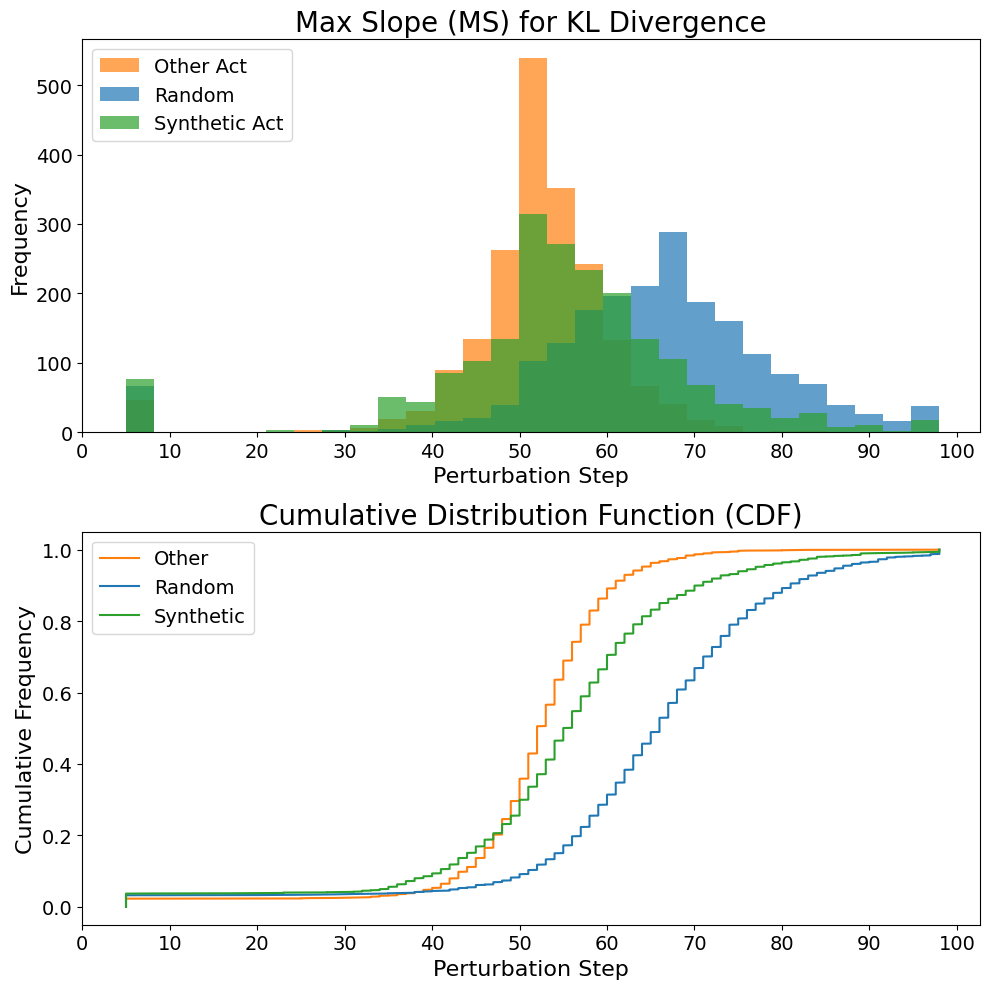

In [123]:
plot_distributions_paper(auc_other, auc_random, auc_synth)

In [124]:
quantify_similarity(auc_other, auc_random, auc_synth)

Similarity score (ms_other vs ms_random): 0.4230
Similarity score (ms_other vs ms_synth): 0.7985
Similarity score (ms_synth vs ms_random): 0.6090
ms_synth is 1.89 times more similar to ms_other than ms_random is.
ms_synth appears to be between ms_other and ms_random in terms of similarity.


In [125]:
print(f"AUC Other Act mean: {np.mean(auc_other)}, Std: {np.std(auc_other):.2f}")
print(f"AUC Synthetic Act mean: {np.mean(auc_synth)}, Std: {np.std(auc_synth):.2f}")
print(f"AUC Random Act mean: {np.mean(auc_random)}, Std: {np.std(auc_random):.2f}")

AUC Other Act mean: 51.7775, Std: 9.95
AUC Synthetic Act mean: 54.7925, Std: 14.87
AUC Random Act mean: 64.633, Std: 15.77


In [126]:
ks_other_synth, _ = stats.kstest(auc_other, auc_synth)
ks_other_random, _ = stats.kstest(auc_other, auc_random)
print(f"KS Other - Synth: {ks_other_synth}")
print(f"KS Other - Random: {ks_other_random}")

KS Other - Synth: 0.2015
KS Other - Random: 0.577


### KL Divergence line plots, histogram for MS 

Task: Appendix A.2 plots (KL divergence line plots and histograms for MS for absolute steps and Main Result (figure 2) line plots to contrast with KL line plots)

In [208]:
results_file = "results_homeschooled_v2_spars100_best_result_absolute.pkl"
with open(f"replications/{results_file}", "rb") as f:
    results = pickle.load(f)

In [209]:
def plot_distributions_paper(ms_other, ms_random, ms_synth):
    plt.figure(figsize=(10, 10))

    # Histogram
    plt.subplot(2, 1, 1)

    # Determine common bins
    all_data = np.concatenate([ms_other, ms_random, ms_synth])
    bins = np.linspace(min(all_data), max(all_data), 30)

    # Plot histograms with common bins and reduced alpha
    plt.hist(
        ms_other,
        bins=bins,
        alpha=0.7,
        label="Other Act",
        density=False,
        color="tab:orange",
    )
    plt.hist(
        ms_random,
        bins=bins,
        alpha=0.7,
        label="Random",
        density=False,
        color="tab:blue",
    )
    plt.hist(
        ms_synth,
        bins=bins,
        alpha=0.7,
        label="Synthetic Act",
        density=False,
        color="tab:green",
    )

    plt.title("Max Slope (MS) for KL Divergence", fontsize=20)
    plt.legend(loc="upper left", fontsize=14)
    plt.xlabel("Perturbation Step", fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    plt.yticks(fontsize=14)

    plt.xticks(np.arange(0, 101, 10), fontsize=14)

    # CDF
    colors = ["tab:orange", "tab:blue", "tab:green"]
    plt.subplot(2, 1, 2)

    for i, (data, label) in enumerate(
        zip([ms_other, ms_random, ms_synth], ["Other Act", "Random", "Synthetic Act"])
    ):
        cdf = np.sort(data)
        plt.plot(cdf, np.linspace(0, 1, len(cdf)), label=label, color=colors[i])

    plt.title("Cumulative Distribution Function (CDF)", fontsize=20)
    plt.legend(loc="upper left", fontsize=14)
    plt.xlabel("Perturbation Step", fontsize=16)
    plt.ylabel("Cumulative Frequency", fontsize=16)
    plt.xticks(np.arange(0, 101, 10), fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()

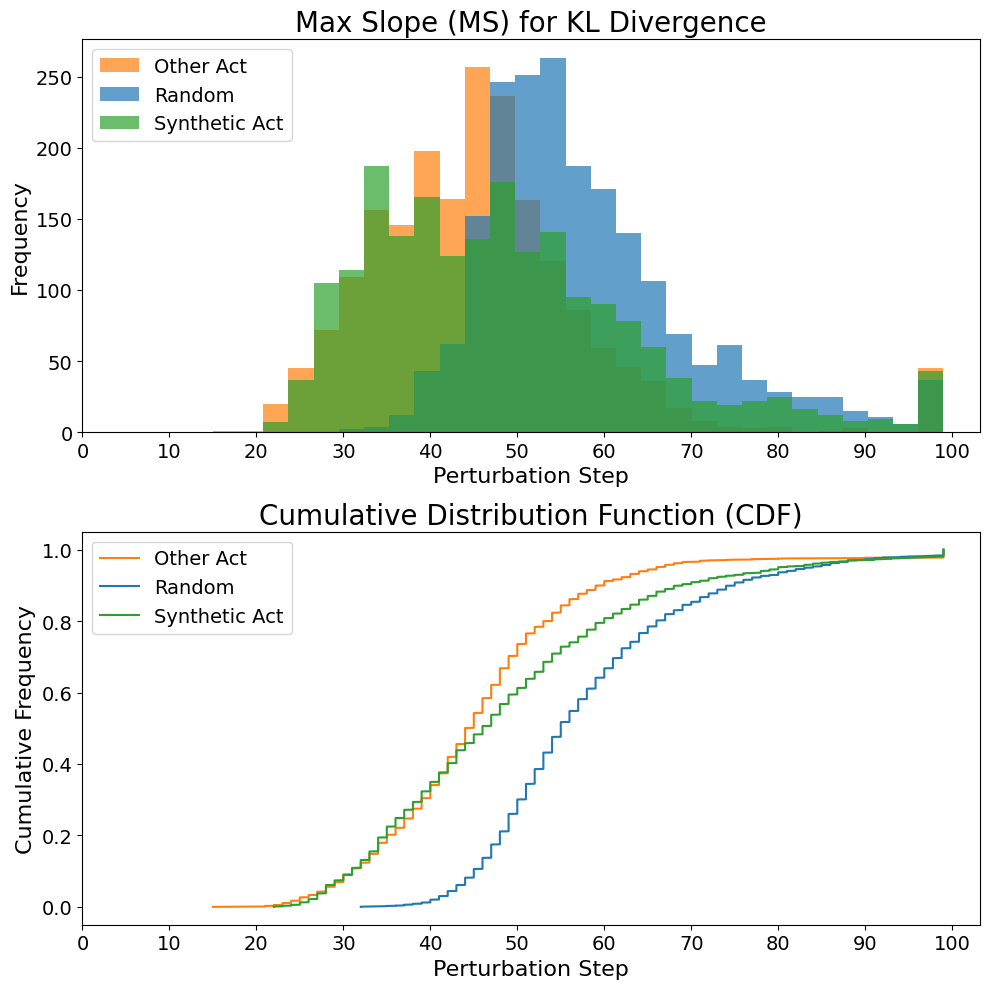

In [210]:
plot_distributions_paper(
    results["kl_div_ms_other"], results["kl_div_ms_random"], results["kl_div_ms_synth"]
)

In [205]:
print(
    f"MS Other Act mean: {np.mean(results['kl_div_ms_other'])}, Std: {np.std(results['kl_div_ms_other']):.2f}"
)
print(
    f"MS Synthetic Act mean: {np.mean(results['kl_div_ms_synth'])}, Std: {np.std(results['kl_div_ms_synth']):.2f}"
)
print(
    f"MS Random Act mean: {np.mean(results['kl_div_ms_random'])}, Std: {np.std(results['kl_div_ms_random']):.2f}"
)

MS Other Act mean: 45.6685, Std: 13.13
MS Synthetic Act mean: 48.628, Std: 15.94
MS Random Act mean: 57.9605, Std: 12.36


In [206]:
ks_other_synth, _ = stats.kstest(results["kl_div_ms_other"], results["kl_div_ms_synth"])
ks_other_random, _ = stats.kstest(
    results["kl_div_ms_other"], results["kl_div_ms_random"]
)
print(f"KS Other - Synth: {ks_other_synth}")
print(f"KS Other - Random: {ks_other_random}")

KS Other - Synth: 0.127
KS Other - Random: 0.4565


### MS Relative Plots
Task: Appendix A.3 plots (Relative step size plots for MS other-act vs random vs synthetic)


In [136]:
results_file = "results_homeschooled_v2_spars100_best_result_relative.pkl"
with open(f"replications/{results_file}", "rb") as f:
    results = pickle.load(f)

In [137]:
ms_synth = results["ms_synth"]
ms_other = results["ms_other"]
ms_random = results["ms_random"]

In [190]:
def plot_distributions_paper(ms_other, ms_random, ms_synth):
    plt.figure(figsize=(10, 10))

    # Histogram
    plt.subplot(2, 1, 1)

    # Determine common bins
    all_data = np.concatenate([ms_other, ms_random, ms_synth])
    bins = np.linspace(min(all_data), max(all_data), 30)

    # Plot histograms with common bins and reduced alpha
    plt.hist(
        ms_other,
        bins=bins,
        alpha=0.7,
        label="Other Act",
        density=False,
        color="tab:orange",
    )
    plt.hist(
        ms_random,
        bins=bins,
        alpha=0.7,
        label="Random",
        density=False,
        color="tab:blue",
    )
    plt.hist(
        ms_synth,
        bins=bins,
        alpha=0.7,
        label="Synthetic Act",
        density=False,
        color="tab:green",
    )

    plt.title("Max Slope (MS) for L2 Distance", fontsize=20)
    plt.legend(loc="upper left", fontsize=14)
    plt.xlabel("Perturbation Step", fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    plt.yticks(fontsize=14)

    plt.xticks(np.arange(0, 101, 10), fontsize=14)

    # CDF
    colors = ["tab:orange", "tab:blue", "tab:green"]
    plt.subplot(2, 1, 2)

    for i, (data, label) in enumerate(
        zip([ms_other, ms_random, ms_synth], ["Other Act", "Random", "Synthetic Act"])
    ):
        cdf = np.sort(data)
        plt.plot(cdf, np.linspace(0, 1, len(cdf)), label=label, color=colors[i])

    plt.title("Cumulative Distribution Function (CDF)", fontsize=20)
    plt.legend(loc="upper left", fontsize=14)
    plt.xlabel("Perturbation Step", fontsize=16)
    plt.ylabel("Cumulative Frequency", fontsize=16)
    plt.xticks(np.arange(0, 101, 10), fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()

In [184]:
results_file = "results_homeschooled_v2_spars100_best_result_relative.pkl"
with open(f"replications/{results_file}", "rb") as f:
    results = pickle.load(f)

In [186]:
ms_other = results["ms_other"]
ms_synth = results["ms_synth"]
ms_random = results["ms_random"]

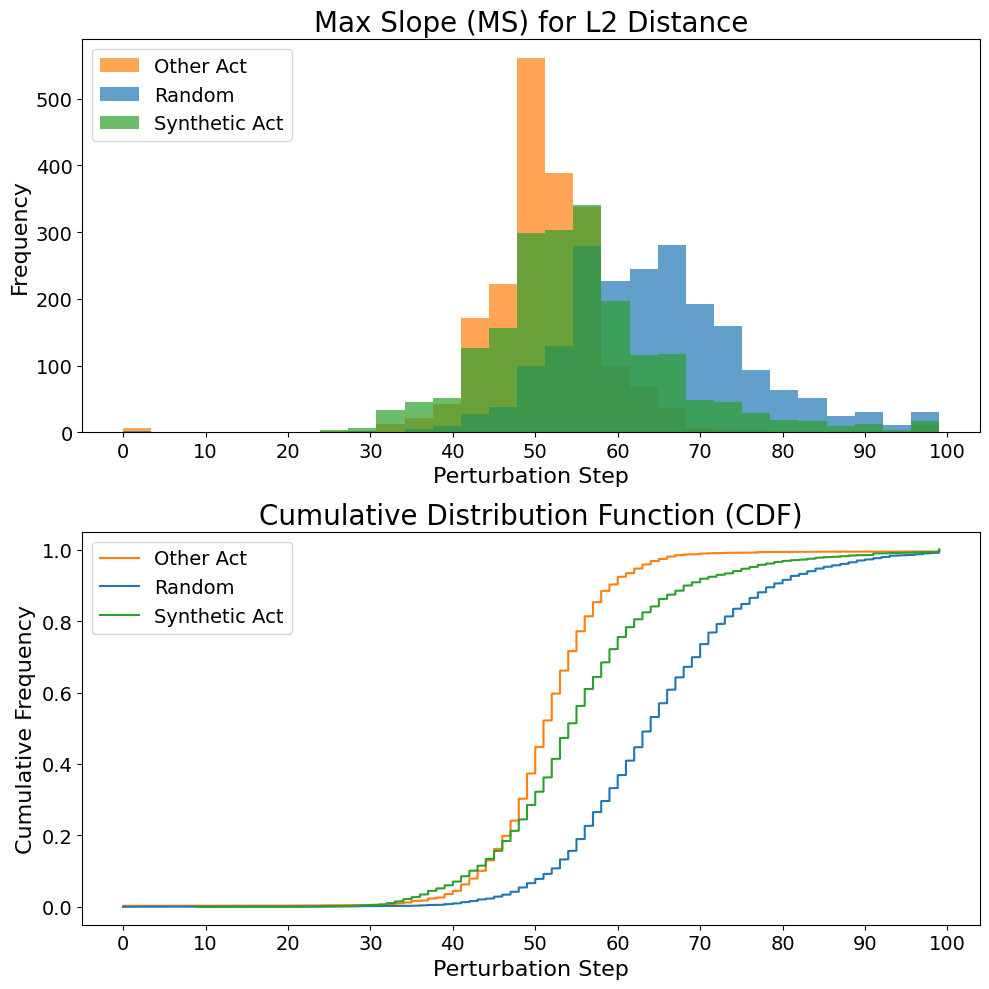

In [191]:
plot_distributions_paper(ms_other, ms_random, ms_synth)

In [141]:
quantify_similarity(ms_other, ms_random, ms_synth)

Similarity score (ms_other vs ms_random): 0.4120
Similarity score (ms_other vs ms_synth): 0.7905
Similarity score (ms_synth vs ms_random): 0.6110
ms_synth is 1.92 times more similar to ms_other than ms_random is.
ms_synth appears to be between ms_other and ms_random in terms of similarity.


In [142]:
print(f"MS Other Act mean: {np.mean(ms_other)}, Std: {np.std(ms_other):.2f}")
print(f"MS Synthetic Act mean: {np.mean(ms_synth)}, Std: {np.std(ms_synth):.2f}")
print(f"MS Random Act mean: {np.mean(ms_random)}, Std: {np.std(ms_random):.2f}")

MS Other Act mean: 51.404, Std: 7.98
MS Synthetic Act mean: 55.2385, Std: 11.30
MS Random Act mean: 64.648, Std: 11.32


In [143]:
ks_other_synth, _ = stats.kstest(ms_other, ms_synth)
ks_other_random, _ = stats.kstest(ms_other, ms_random)
print(f"KS Other - Synth: {ks_other_synth}")
print(f"KS Other - Random: {ks_other_random}")

KS Other - Synth: 0.2095
KS Other - Random: 0.588


### Recon Other Plots
Appendix A.4 plots (MS for other-act vs random vs recon-other-act absolute step and relative step)

#### Relative Step Size

In [192]:
results_file = "results_homeschooled_v2_spars100_best_result_relative.pkl"
with open(f"replications/{results_file}", "rb") as f:
    results = pickle.load(f)

In [193]:
ms_other = results["ms_other"]
ms_recon_other = results["ms_recon_other"]
ms_random = results["ms_random"]

In [194]:
def plot_distributions_paper(ms_other, ms_random, ms_recon_other):
    plt.figure(figsize=(10, 10))

    # Histogram
    plt.subplot(2, 1, 1)

    # Determine common bins
    all_data = np.concatenate([ms_other, ms_random, ms_recon_other])
    bins = np.linspace(min(all_data), max(all_data), 30)

    # Plot histograms with common bins and reduced alpha
    plt.hist(
        ms_other,
        bins=bins,
        alpha=0.7,
        label="Other Act",
        density=False,
        color="tab:orange",
    )
    plt.hist(
        ms_random,
        bins=bins,
        alpha=0.7,
        label="Random",
        density=False,
        color="tab:blue",
    )
    plt.hist(
        ms_recon_other,
        bins=bins,
        alpha=0.7,
        label="Recon Other Act",
        density=False,
        color="tab:brown",
    )

    plt.title("Max Slope (MS) for L2 Distance", fontsize=20)
    plt.legend(loc="upper left", fontsize=14)
    plt.xlabel("Perturbation Step", fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    plt.yticks(fontsize=14)

    plt.xticks(np.arange(0, 101, 10), fontsize=14)

    # CDF
    colors = ["tab:orange", "tab:blue", "tab:brown"]
    plt.subplot(2, 1, 2)

    for i, (data, label) in enumerate(
        zip(
            [ms_other, ms_random, ms_recon_other],
            ["Other Act", "Random", "Recon Other Act"],
        )
    ):
        cdf = np.sort(data)
        plt.plot(cdf, np.linspace(0, 1, len(cdf)), label=label, color=colors[i])

    plt.title("Cumulative Distribution Function (CDF)", fontsize=20)
    plt.legend(loc="upper left", fontsize=14)
    plt.xlabel("Perturbation Step", fontsize=16)
    plt.ylabel("Cumulative Frequency", fontsize=16)
    plt.xticks(np.arange(0, 101, 10), fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()

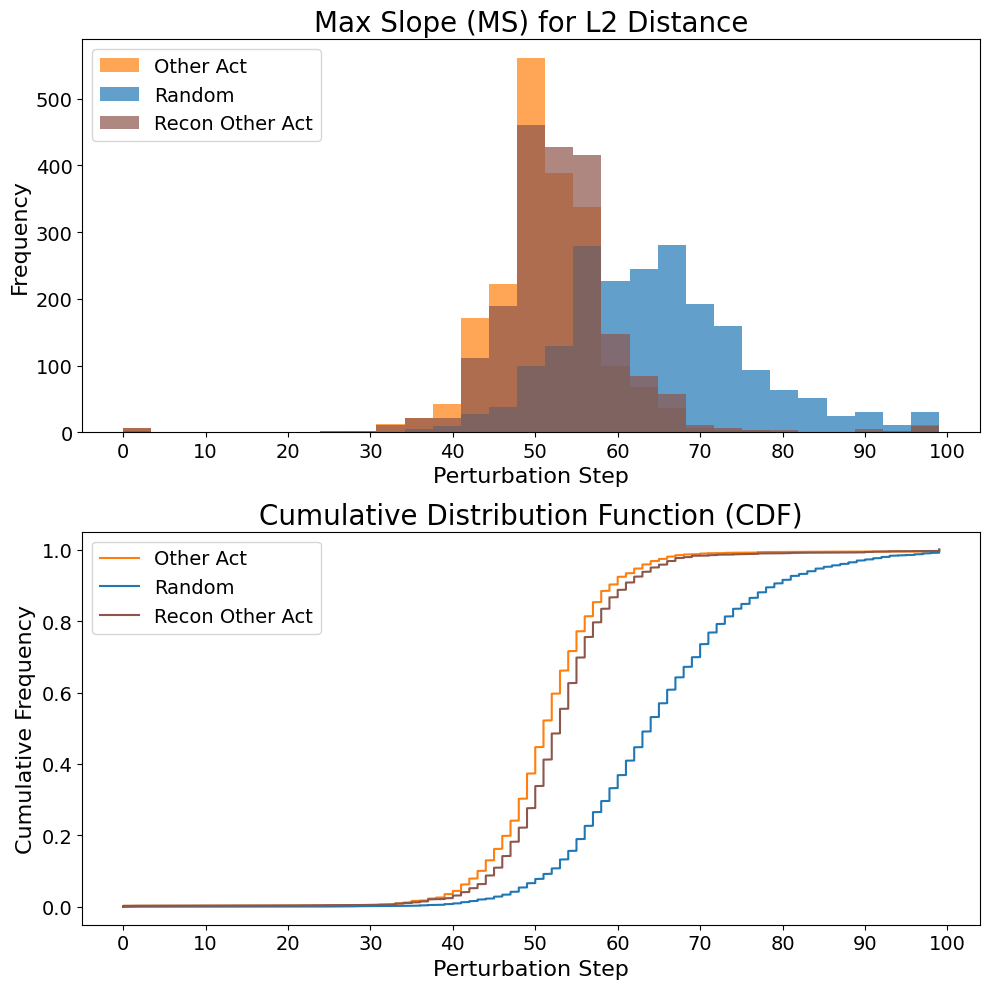

In [195]:
plot_distributions_paper(ms_other, ms_random, ms_recon_other)

In [196]:
quantify_similarity(ms_other, ms_random, ms_recon_other)

Similarity score (ms_other vs ms_random): 0.4120
Similarity score (ms_other vs ms_synth): 0.8885
Similarity score (ms_synth vs ms_random): 0.4620
ms_synth is 2.16 times more similar to ms_other than ms_random is.
ms_synth appears to be between ms_other and ms_random in terms of similarity.


In [197]:
print(f"MS Other Act mean: {np.mean(ms_other)}, Std: {np.std(ms_other):.2f}")
print(
    f"MS Recon Other Act mean: {np.mean(ms_recon_other)}, Std: {np.std(ms_recon_other):.2f}"
)
print(f"MS Random Act mean: {np.mean(ms_random)}, Std: {np.std(ms_random):.2f}")

MS Other Act mean: 51.404, Std: 7.98
MS Recon Other Act mean: 52.9495, Std: 8.22
MS Random Act mean: 64.648, Std: 11.32


In [198]:
ks_other_recon_other, _ = stats.kstest(ms_other, ms_recon_other)
ks_other_random, _ = stats.kstest(ms_other, ms_random)
print(f"KS Other - Recon Other: {ks_other_recon_other}")
print(f"KS Other - Random: {ks_other_random}")

KS Other - Recon Other: 0.1115
KS Other - Random: 0.588


#### Absolute Step Size

In [172]:
results_file = "results_homeschooled_v2_spars100_best_result_absolute.pkl"
with open(f"replications/{results_file}", "rb") as f:
    results = pickle.load(f)

In [173]:
ms_other = results["ms_other"]
ms_recon_other = results["ms_recon_other"]
ms_random = results["ms_random"]

In [176]:
def plot_distributions_paper(ms_other, ms_random, ms_recon_other):
    plt.figure(figsize=(10, 10))

    # Histogram
    plt.subplot(2, 1, 1)

    # Determine common bins
    all_data = np.concatenate([ms_other, ms_random, ms_recon_other])
    bins = np.linspace(min(all_data), max(all_data), 30)

    # Plot histograms with common bins and reduced alpha
    plt.hist(
        ms_other,
        bins=bins,
        alpha=0.7,
        label="Other Act",
        density=False,
        color="tab:orange",
    )
    plt.hist(
        ms_random,
        bins=bins,
        alpha=0.7,
        label="Random",
        density=False,
        color="tab:blue",
    )
    plt.hist(
        ms_recon_other,
        bins=bins,
        alpha=0.7,
        label="Recon Other Act",
        density=False,
        color="tab:brown",
    )

    plt.title("Max Slope (MS) for L2 Distance", fontsize=20)
    plt.legend(loc="upper left", fontsize=14)
    plt.xlabel("Perturbation Step", fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    plt.yticks(fontsize=14)

    plt.xticks(np.arange(0, 101, 10), fontsize=14)

    # CDF
    colors = ["tab:orange", "tab:blue", "tab:brown"]
    plt.subplot(2, 1, 2)

    for i, (data, label) in enumerate(
        zip(
            [ms_other, ms_random, ms_recon_other],
            ["Other Act", "Random", "Recon Other Act"],
        )
    ):
        cdf = np.sort(data)
        plt.plot(cdf, np.linspace(0, 1, len(cdf)), label=label, color=colors[i])

    plt.title("Cumulative Distribution Function (CDF)", fontsize=20)
    plt.legend(loc="upper left", fontsize=14)
    plt.xlabel("Perturbation Step", fontsize=16)
    plt.ylabel("Cumulative Frequency", fontsize=16)
    plt.xticks(np.arange(0, 101, 10), fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()

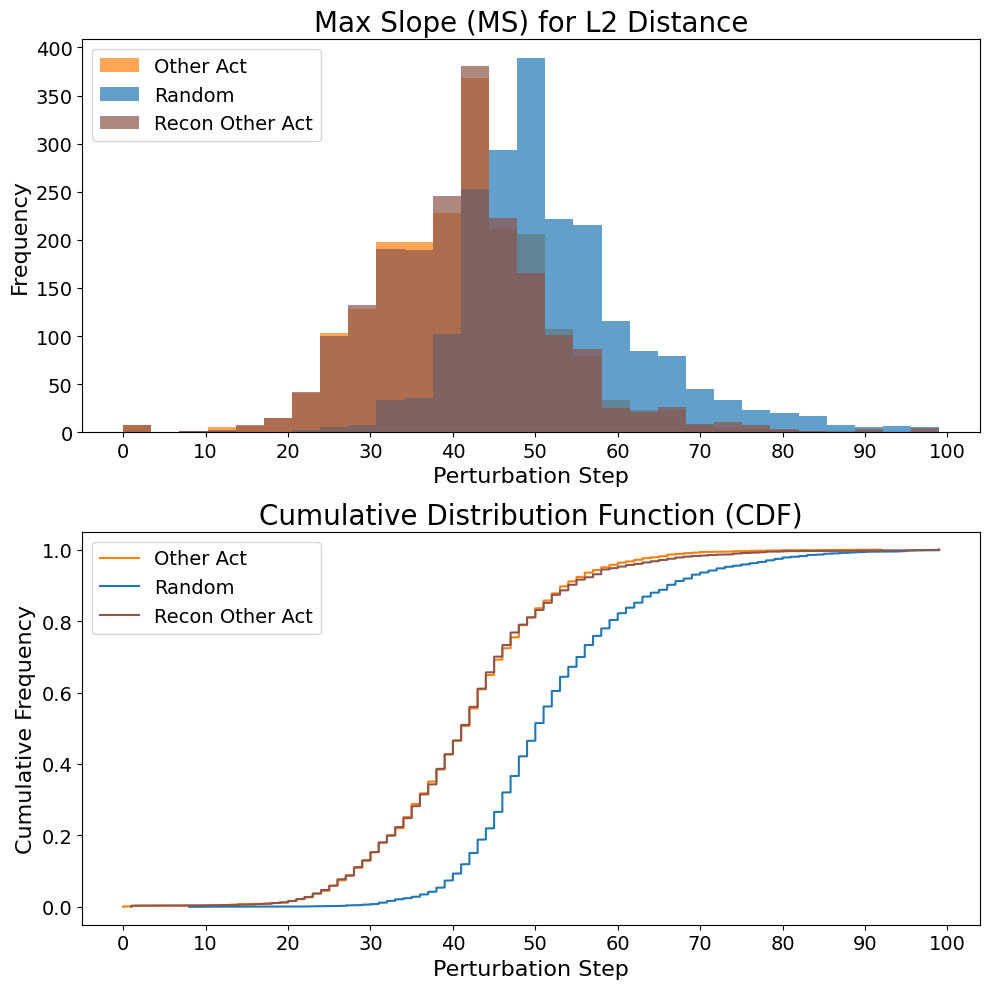

In [177]:
plot_distributions_paper(ms_other, ms_random, ms_recon_other)

In [164]:
quantify_similarity(ms_other, ms_random, ms_recon_other)

Similarity score (ms_other vs ms_random): 0.5710
Similarity score (ms_other vs ms_synth): 0.9865
Similarity score (ms_synth vs ms_random): 0.5635
ms_synth is 1.73 times more similar to ms_other than ms_random is.
ms_synth does not appear to be between ms_other and ms_random in terms of similarity.


In [165]:
print(f"MS Other Act mean: {np.mean(ms_other)}, Std: {np.std(ms_other):.2f}")
print(
    f"MS Recon Other Act mean: {np.mean(ms_recon_other)}, Std: {np.std(ms_recon_other):.2f}"
)
print(f"MS Random Act mean: {np.mean(ms_random)}, Std: {np.std(ms_random):.2f}")

MS Other Act mean: 41.1225, Std: 10.53
MS Recon Other Act mean: 41.379, Std: 11.23
MS Random Act mean: 52.0595, Std: 10.94


In [166]:
ks_other_recon_other, _ = stats.kstest(ms_other, ms_recon_other)
ks_other_random, _ = stats.kstest(ms_other, ms_random)
print(f"KS Other - Recon Other: {ks_other_recon_other}")
print(f"KS Other - Random: {ks_other_random}")

KS Other - Recon Other: 0.0135
KS Other - Random: 0.429


### Main Plot

In [8]:
results_file = "results_homeschooled_v2_spars100_best_result_absolute.pkl"
with open(f"replications/{results_file}", "rb") as f:
    results = pickle.load(f)

In [15]:
def plot_distributions_paper(ms_other, ms_random, ms_synth):
    plt.figure(figsize=(10, 10))

    # Histogram
    plt.subplot(2, 1, 1)

    # Determine common bins
    all_data = np.concatenate([ms_other, ms_random, ms_synth])
    bins = np.linspace(min(all_data), max(all_data), 30)

    # Plot histograms with common bins and reduced alpha
    plt.hist(
        ms_other,
        bins=bins,
        alpha=0.7,
        label="Other Act",
        density=False,
        color="tab:orange",
    )
    plt.hist(
        ms_random,
        bins=bins,
        alpha=0.7,
        label="Random",
        density=False,
        color="tab:blue",
    )
    plt.hist(
        ms_synth,
        bins=bins,
        alpha=0.7,
        label="Synthetic Act",
        density=False,
        color="tab:green",
    )

    plt.title("Max Slope (MS) for L2 Distance", fontsize=20)
    plt.legend(loc="upper left", fontsize=14)
    plt.xlabel("Perturbation Step", fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    plt.yticks(fontsize=14)

    plt.xticks(np.arange(0, 101, 10), fontsize=14)

    # CDF
    colors = ["tab:orange", "tab:blue", "tab:green"]
    plt.subplot(2, 1, 2)

    for i, (data, label) in enumerate(
        zip([ms_other, ms_random, ms_synth], ["Other Act", "Random", "Synthetic Act"])
    ):
        cdf = np.sort(data)
        plt.plot(cdf, np.linspace(0, 1, len(cdf)), label=label, color=colors[i])

    plt.title("Cumulative Distribution Function (CDF)", fontsize=20)
    plt.legend(loc="upper left", fontsize=14)
    plt.xlabel("Perturbation Step", fontsize=16)
    plt.ylabel("Cumulative Frequency", fontsize=16)
    plt.xticks(np.arange(0, 101, 10), fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()

In [16]:
ms_synth = results["ms_synth"]
ms_other = results["ms_other"]
ms_random = results["ms_random"]

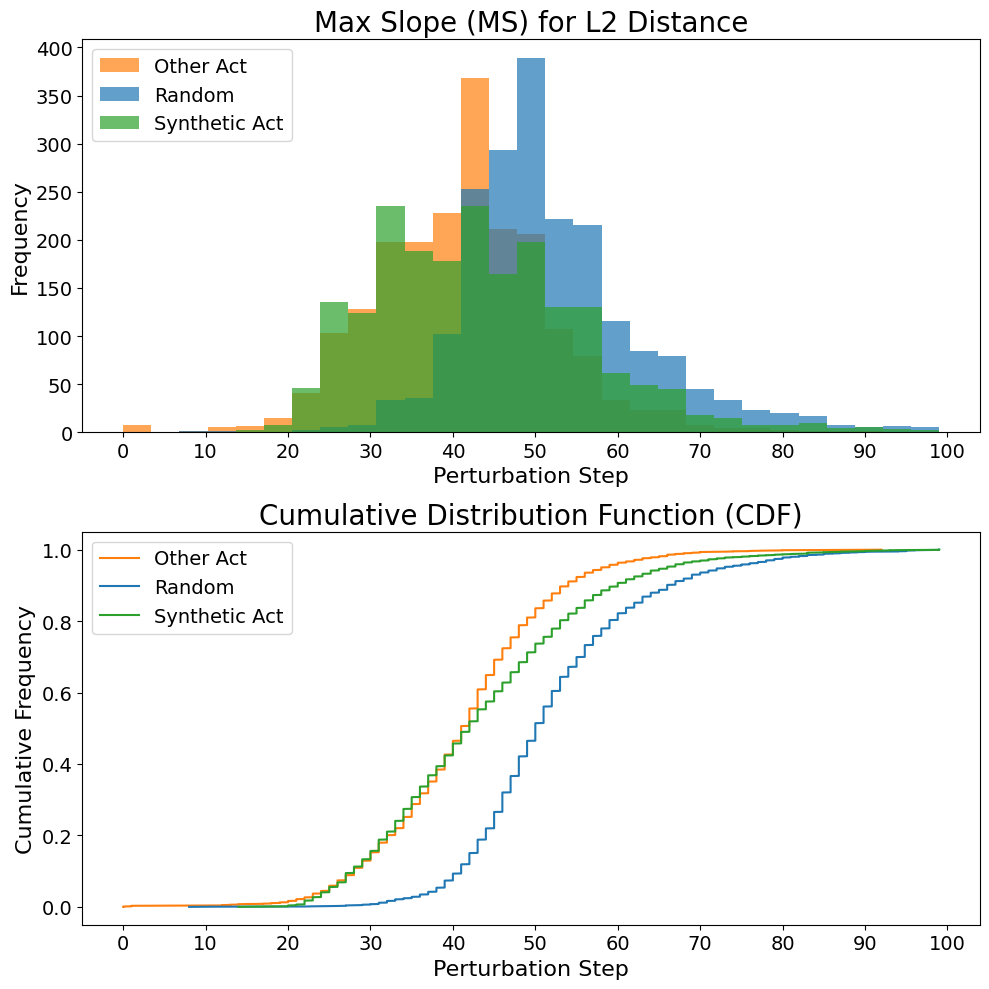

In [17]:
plot_distributions_paper(ms_other, ms_random, ms_synth)